                                            **** Progetto Computer Vision ****

# Prima fase: caricamento e visualizzazione dei dati

## Codice

Numero di immagini: 270
Classi nel dataset: ['Train']


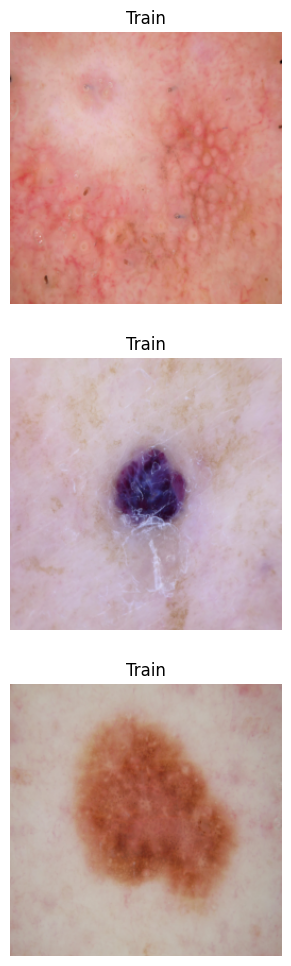

In [1]:
import torch
import torch.optim as optim
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import seaborn as sns
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import torch.nn.functional as F
from imblearn.over_sampling import RandomOverSampler

# Definisci le trasformazioni da applicare alle immagini
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Ridimensionamento delle immagini
    transforms.ToTensor(),          # Converte le immagini in tensori
])

# Carica il dataset
dataset = datasets.ImageFolder(
    root="/Users/giulia/Desktop/CV_Project_Isinelli-DiMauro/ISIC_dataset",
    transform=transform
)

# Carica i dati in un DataLoader per il batch processing
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Visualizza alcune informazioni sul dataset
print(f"Numero di immagini: {len(dataset)}")
print(f"Classi nel dataset: {dataset.classes}")

# Definisci il numero di immagini da visualizzare per classe
num_images_per_class = 3
class_samples = {cls: 0 for cls in dataset.classes}

# Crea una figura per visualizzare le immagini
plt.figure(figsize=(12, 12))

# Itera sui batch e raccogli immagini da diverse classi
for images, labels in dataloader:
    for i in range(len(images)):
        label = labels[i].item()
        class_name = dataset.classes[label]
        
        # Aggiungi l'immagine alla visualizzazione se non sono state ancora mostrate abbastanza immagini per quella classe
        if class_samples[class_name] < num_images_per_class:
            ax = plt.subplot(num_images_per_class, len(dataset.classes), class_samples[class_name] * len(dataset.classes) + dataset.classes.index(class_name) + 1)
            image = images[i].permute(1, 2, 0)  # Converte il formato dei tensori da (C, H, W) a (H, W, C)
            ax.imshow(image)
            ax.axis('off')  # Nasconde gli assi
            ax.set_title(class_name)
            class_samples[class_name] += 1

        # Se abbiamo mostrato abbastanza immagini per tutte le classi, interrompi
        if all(count >= num_images_per_class for count in class_samples.values()):
            break
    if all(count >= num_images_per_class for count in class_samples.values()):
        break

plt.show()

# Seconda fase: definizione del modello, addestramento del modello e classificazione delle immagini

## Definizione e addestramento del modello

Epoch 1/15, Train Loss: 2.6854, Train Accuracy: 14.20%, Test Loss: 2.3119, Test Accuracy: 16.67%
Epoch 2/15, Train Loss: 2.1898, Train Accuracy: 30.25%, Test Loss: 2.0641, Test Accuracy: 23.15%
Epoch 3/15, Train Loss: 1.6524, Train Accuracy: 46.91%, Test Loss: 1.9802, Test Accuracy: 26.85%
Epoch 4/15, Train Loss: 1.4623, Train Accuracy: 48.77%, Test Loss: 1.7913, Test Accuracy: 30.56%
Epoch 5/15, Train Loss: 1.5727, Train Accuracy: 56.79%, Test Loss: 1.8164, Test Accuracy: 36.11%
Epoch 6/15, Train Loss: 1.1589, Train Accuracy: 61.73%, Test Loss: 1.6225, Test Accuracy: 38.89%
Epoch 7/15, Train Loss: 1.4641, Train Accuracy: 54.94%, Test Loss: 1.7169, Test Accuracy: 34.26%
Epoch 8/15, Train Loss: 1.1598, Train Accuracy: 62.96%, Test Loss: 1.6902, Test Accuracy: 35.19%
Epoch 9/15, Train Loss: 1.1728, Train Accuracy: 60.49%, Test Loss: 1.7014, Test Accuracy: 40.74%
Epoch 10/15, Train Loss: 1.3627, Train Accuracy: 63.58%, Test Loss: 1.6277, Test Accuracy: 36.11%
Epoch 11/15, Train Loss: 1.28

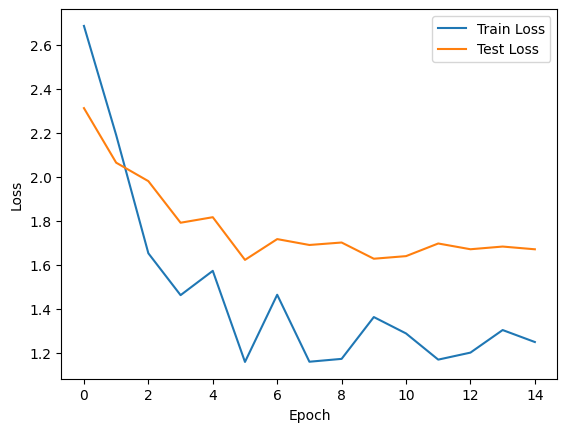

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torchvision.models import resnet18, ResNet18_Weights

# Trasformazioni per preprocessare le immagini con data augmentation e normalizzazione
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Flip orizzontale casuale
    transforms.RandomRotation(20),      # Rotazione casuale
    transforms.Resize((128, 128)),      # Ridimensionamento delle immagini
    transforms.ToTensor(),              # Converte le immagini in tensori
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizzazione
])

# Carica tutte le immagini in una lista
image_paths = []
labels = []

# Directory principale del dataset
dataset_dir = "/Users/giulia/Desktop/CV_Project_Isinelli-DiMauro/ISIC_dataset"

# Itera su tutte le sottocartelle di malattie
for label, disease_folder in enumerate(os.listdir(os.path.join(dataset_dir, "train"))):
    disease_path = os.path.join(dataset_dir, "train", disease_folder)
    if os.path.isdir(disease_path):
        for img_name in os.listdir(disease_path):
            if img_name.endswith(('.jpg', '.png')):
                img_path = os.path.join(disease_path, img_name)
                image_paths.append(img_path)
                labels.append(label)

# Usa train_test_split per dividere le immagini in training e test (80% training, 20% test)
train_img_paths, test_img_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.4, random_state=42, stratify=labels
)

# Creazione di un Dataset personalizzato
class CustomDataset(Dataset):
    def __init__(self, img_paths, labels, transform=None):
        self.img_paths = img_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        label = self.labels[idx]
        
        # Carica l'immagine
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Crea i DataLoader per train e test
train_dataset = CustomDataset(train_img_paths, train_labels, transform=transform)
test_dataset = CustomDataset(test_img_paths, test_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Modello ResNet-18 con Dropout e regolarizzazione L2
model = resnet18(weights=ResNet18_Weights.DEFAULT)  # Carica ResNet-18 con pesi pre-addestrati
model.fc = nn.Sequential(
    nn.Dropout(p=0.5),  # Dropout con probabilità 50% per evitare overfitting
    nn.Linear(model.fc.in_features, len(set(labels)))  # Ultimo layer di classificazione
)

# Funzione di addestramento
def train_model(model, train_loader, test_loader, num_epochs=15, lr=0.0001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss()

    # Ottimizzatore con regolarizzazione L2 (weight_decay)
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)  # L2 regularization

    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # Scheduler

    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total
        train_losses.append(epoch_loss)

        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        test_loss /= len(test_loader)
        test_accuracy = 100 * correct / total
        test_losses.append(test_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_accuracy:.2f}%, "
              f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

        scheduler.step()

    return train_losses, test_losses

# Addestriamo il modello
train_losses, test_losses = train_model(model, train_loader, test_loader, num_epochs=15, lr=0.0001)

# Visualizza le curve di perdita
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Visualizzazione andamento del modello

Classification Report:

                            precision    recall  f1-score   support

         actinic keratosis     0.0000    0.0000    0.0000         6
      basal cell carcinoma     0.5000    0.6667    0.5714         6
            dermatofibroma     0.1667    0.1667    0.1667         6
                  melanoma     0.8000    0.6667    0.7273         6
                     nevus     0.1429    0.1667    0.1538         6
pigmented benign keratosis     0.4000    0.3333    0.3636         6
      seborrheic keratosis     1.0000    0.8333    0.9091         6
   squamous cell carcinoma     0.1667    0.1667    0.1667         6
           vascular lesion     0.5000    0.5000    0.5000         6

                  accuracy                         0.3889        54
                 macro avg     0.4085    0.3889    0.3954        54
              weighted avg     0.4085    0.3889    0.3954        54



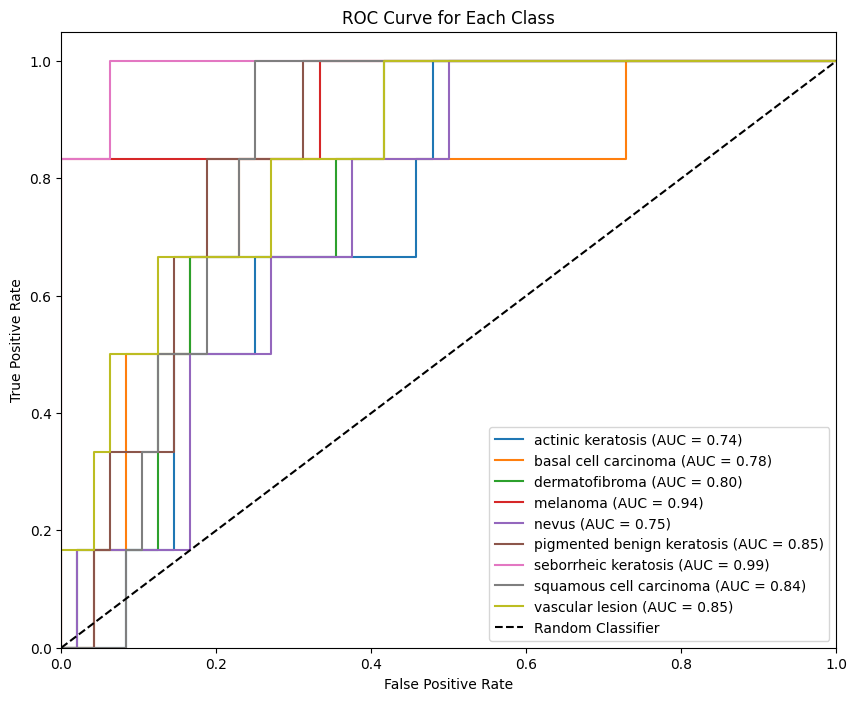


Mean AUC: 0.8372


In [3]:
import torch
from sklearn.metrics import classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import label_binarize

# Assicurati che il modello e i dati siano sulla GPU (se disponibile) o sulla CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Funzione per calcolare il report di classificazione e la curva ROC
def evaluate_model(model, test_loader, class_names):
    model.eval()
    model.to(device)  # Assicurati che il modello sia sulla stessa device
    all_labels = []
    all_preds = []
    all_probs = []  # Probabilità per la ROC

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)  # Trasferisci immagini e etichette alla device
            outputs = model(images)
            
            # Calcoliamo le probabilità (softmax per ottenere le probabilità)
            probs = torch.softmax(outputs, dim=1)
            
            # Otteniamo le etichette predette (classe con probabilità massima)
            _, predicted = torch.max(outputs, 1)
            
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Report di classificazione
    print("Classification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))
    
    # Prepariamo le etichette per la curva ROC (one-hot encoding)
    y_true = label_binarize(all_labels, classes=[i for i in range(len(class_names))])

    # Calcoliamo la curva ROC e l'AUC per ogni classe
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(len(class_names)):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], np.array(all_probs)[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot della curva ROC
    plt.figure(figsize=(10, 8))
    for i in range(len(class_names)):
        plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Each Class')
    plt.legend(loc='lower right')
    plt.show()

    # Calcoliamo la media dell'AUC
    mean_auc = np.mean(list(roc_auc.values()))
    print(f"\nMean AUC: {mean_auc:.4f}")

# Nomi delle malattie (assicurati che l'ordine corrisponda alle etichette delle classi nel tuo dataset)
class_names = [
    'actinic keratosis', 
    'basal cell carcinoma', 
    'dermatofibroma', 
    'melanoma', 
    'nevus', 
    'pigmented benign keratosis', 
    'seborrheic keratosis', 
    'squamous cell carcinoma', 
    'vascular lesion'
]

# Eseguiamo la valutazione del modello
evaluate_model(model, test_loader, class_names)

# Terza fase: visualizzazione risultati

	• Questo flusso di codice permette di esaminare come il modello di deep learning sta classificando le immagini del set di test, permettendo di visualizzare i risultati del modello e di vedere se ci sono pattern o errori sistematici.
 
	• È utile soprattutto per valutare le prestazioni del modello su diverse classi e visualizzare esempi di immagini che il modello ha classificato correttamente, per una migliore interpretabilità e analisi del modello.

## Benchmarking

In [4]:
import torch
import time
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torchvision.models import resnet18, ResNet18_Weights

# Funzione di benchmarking
def benchmark_model(model, test_loader, device, num_classes=9):
    model.eval()  # Assicurati che il modello sia in modalità di valutazione
    
    # Variabili per memorizzare le etichette reali e le etichette predette
    all_labels = []
    all_preds = []
    
    # Inizia il cronometro
    start_time = time.time()
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            # Previsioni
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            # Memorizza le etichette vere e predette
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    
    # Calcola il tempo impiegato per fare le previsioni
    inference_time = time.time() - start_time
    print(f"Inference time: {inference_time:.4f} seconds")
    
    # Calcola le metriche di valutazione
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Accuracy: {accuracy:.4f}")
    
    # Report di classificazione
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, digits=4))
    
    return accuracy, inference_time


# Funzione di benchmarking con GPU/CPU
def run_benchmark():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Running on device: {device}")
    
    # Esegui il benchmarking
    accuracy, inference_time = benchmark_model(model, test_loader, device)
    
    # Aggiungi eventuali altre metriche di interesse o grafici
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Inference Time: {inference_time:.4f} seconds")
    
    return accuracy, inference_time

# Esegui il benchmarking
run_benchmark()

Running on device: cpu
Inference time: 0.9146 seconds
Accuracy: 0.3889

Classification Report:
              precision    recall  f1-score   support

           0     0.1667    0.1667    0.1667         6
           1     0.4444    0.6667    0.5333         6
           2     0.1429    0.1667    0.1538         6
           3     0.6000    0.5000    0.5455         6
           4     0.0000    0.0000    0.0000         6
           5     0.4286    0.5000    0.4615         6
           6     1.0000    0.8333    0.9091         6
           7     0.1667    0.1667    0.1667         6
           8     0.5000    0.5000    0.5000         6

    accuracy                         0.3889        54
   macro avg     0.3832    0.3889    0.3818        54
weighted avg     0.3832    0.3889    0.3818        54

Test Accuracy: 0.3889
Inference Time: 0.9146 seconds


(0.3888888888888889, 0.9146308898925781)

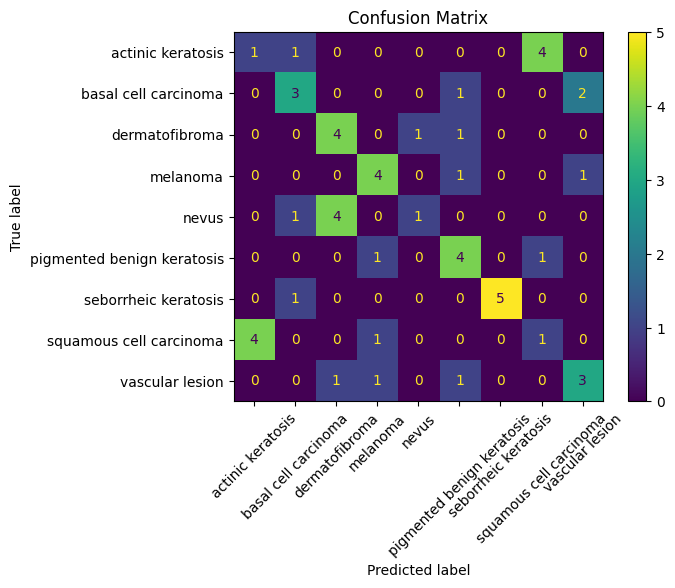

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
import matplotlib.pyplot as plt

# Funzione per generare la confusion matrix
def plot_confusion_matrix(model, test_loader, class_names):
    model.eval()
    model.to(device)  # Assicurati che il modello sia sulla stessa device
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)  # Ottieni le classi predette
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    
    # Calcoliamo la confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=[i for i in range(len(class_names))])

    # Mostriamo la confusion matrix in formato grafico
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='viridis', xticks_rotation=45)
    plt.title("Confusion Matrix")
    plt.show()

# Nomi delle malattie (assicurati che l'ordine corrisponda alle etichette delle classi nel tuo dataset)
class_names = [
    'actinic keratosis', 
    'basal cell carcinoma', 
    'dermatofibroma', 
    'melanoma', 
    'nevus', 
    'pigmented benign keratosis', 
    'seborrheic keratosis', 
    'squamous cell carcinoma', 
    'vascular lesion'
]

# Plot della confusion matrix
plot_confusion_matrix(model, test_loader, class_names)

## Codice

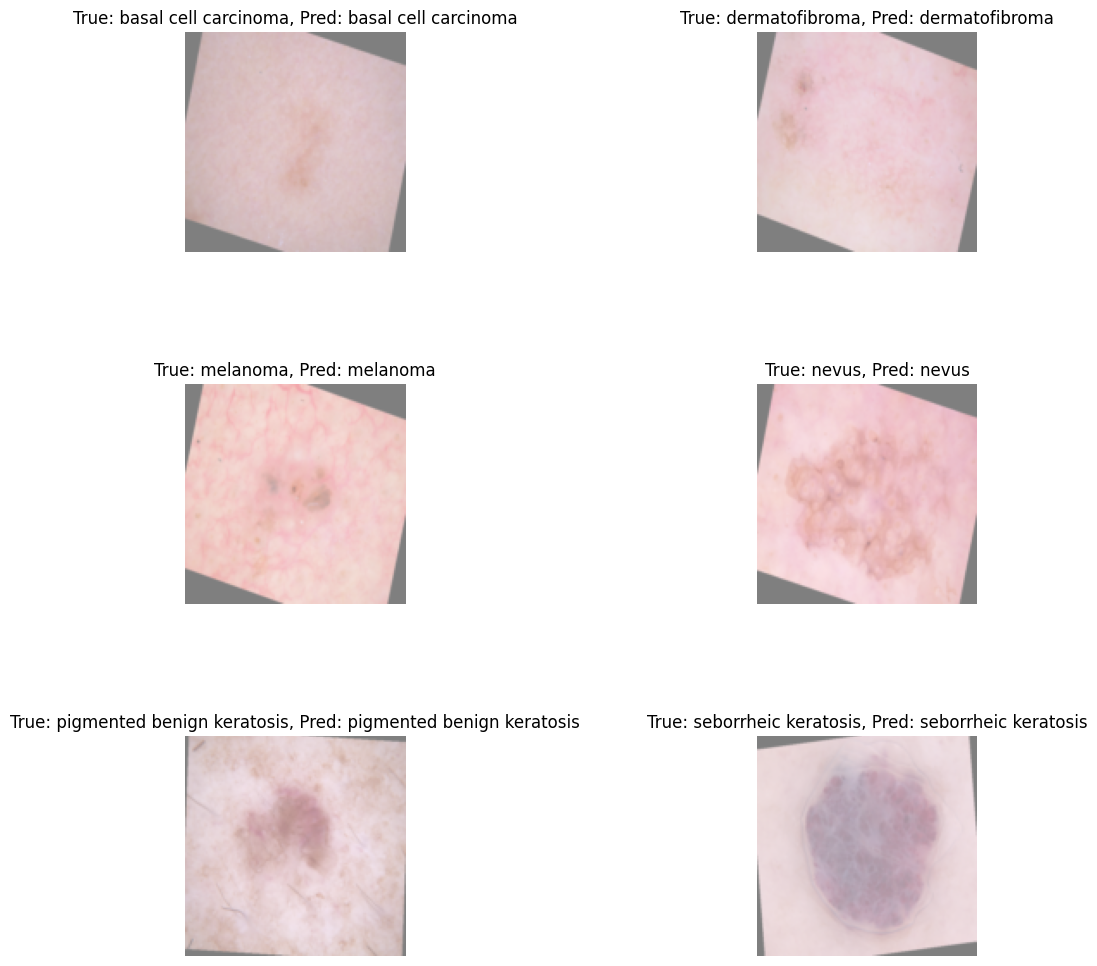

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Funzione per denormalizzare
def denormalize(tensor, mean, std):
    # Formula inversa per denormalizzare
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

# Funzione per visualizzare immagini
def imshow(img, title):
    img = denormalize(img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Denormalizza
    img = img / 2 + 0.5  # Ripristina il range per visualizzare correttamente (opzionale)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Trasponi per visualizzare correttamente
    plt.title(title)
    plt.axis('off')  # Non mostrare gli assi

# Funzione per fare previsioni sul set di test e visualizzare un esempio per ogni classe
def show_one_correct_image_per_class(model, test_loader, test_dataset):
    model.eval()
    class_images = {class_name: None for class_name in test_dataset.classes}  # Dizionario per tracciare un'immagine per classe
    correct_images = []
    correct_titles = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            for idx in range(len(labels)):
                label = labels[idx]
                predicted_label = predicted[idx]
                if label == predicted_label:  # Solo se l'immagine è correttamente classificata
                    class_name = test_dataset.classes[label.item()]  # Usa .item() per ottenere il valore int
                    # Se non abbiamo già trovato un'immagine per quella classe
                    if class_images[class_name] is None:
                        class_images[class_name] = (images[idx], label, predicted_label)
                    
                    # Controlliamo se abbiamo trovato un'immagine per tutte le classi
                    if all(class_images[class_name] is not None for class_name in class_images):
                        break

            # Se tutte le classi sono state trovate, fermiamo il ciclo
            if all(class_images[class_name] is not None for class_name in class_images):
                break

    # Aggiungiamo le immagini correttamente classificate al loro dizionario
    for class_name, image_data in class_images.items():
        if image_data is not None:  # Assicuriamoci di aggiungere solo le classi con immagini trovate
            img, label, predicted_label = image_data
            title = f"True: {class_name}, Pred: {test_dataset.classes[predicted_label.item()]}"
            correct_images.append(img)
            correct_titles.append(title)

    # Limitiamo a 6 immagini da visualizzare (se ce ne sono più di 6)
    correct_images = correct_images[:6]
    correct_titles = correct_titles[:6]

    # Visualizza le immagini correttamente classificate con dimensioni più piccole e maggiore spazio
    plt.figure(figsize=(12, 12))  # Aumenta la dimensione della figura per più spazio
    for i in range(len(correct_images)):
        plt.subplot(3, 2, i + 1)  # 3 righe e 2 colonne
        imshow(correct_images[i], correct_titles[i])
    
    # Aumenta lo spazio tra le immagini
    plt.subplots_adjust(wspace=0.6, hspace=0.6)  # Aumenta lo spazio orizzontale e verticale tra le immagini
    plt.show()

# Aggiungi la lista di classi al tuo dataset personalizzato
class CustomDataset(Dataset):
    def __init__(self, img_paths, labels, transform=None, classes=None):
        self.img_paths = img_paths
        self.labels = labels
        self.transform = transform
        self.classes = classes  # Aggiungi questo attributo per le classi

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        label = self.labels[idx]
        
        # Carica l'immagine
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Definire le classi
class_names = ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']

# Creazione del dataset
train_dataset = CustomDataset(train_img_paths, train_labels, transform=transform, classes=class_names)
test_dataset = CustomDataset(test_img_paths, test_labels, transform=transform, classes=class_names)

# Ora puoi chiamare la funzione
show_one_correct_image_per_class(model, test_loader, test_dataset)